# Spotify Audio Features

In [2]:
%load_ext autoreload
%autoreload 2

## Fetch user track features

### Spotify API Client & Authentication

In [3]:
import spotipy

In [6]:
ACCESS_TOKEN = "BQDTzu7Hlhj3lhdriaSKVJdxizefalZvRGG9zUAp26pi7_d-yhFRO1wAVGCa6JnfmkVhYoBWjpfz07lIMnLT63zt6Xh1mPMnnHtKNNnxOz1yUw5TNrIdvt5mT5nZPUJ_E2OEgAC_57KdkjUSjbHls7eLfXGwwp3LngeVDg67LjE"
spotify = spotipy.Spotify(auth=ACCESS_TOKEN)

### Fetch current user's tracks

In [7]:
result = spotify.current_user_saved_tracks(limit=50)
track_list = [user_track["track"] for user_track in result["items"]]

### Query Spotify API for audio features

In [8]:
# Extract track IDs so we can fetch additional info
track_id_list = [track["id"] for track in track_list]
# Get track audio features
track_features_list = spotify.audio_features(track_id_list)
# Get track audio analysis
# track_analysis_list = [spotify.audio_analysis(track_id) for track_id in track_id_list]
import asyncio
loop = asyncio.get_running_loop()
track_analysis_list = await asyncio.gather(*[loop.run_in_executor(None, spotify.audio_analysis, track_id) for track_id in track_id_list])

### Construct & normalize audio features

In [12]:
from smoothify.features import construct_features

In [20]:
features_df = construct_features(track_list=track_list, audio_features_list=track_features_list, audio_analysis_list=track_analysis_list)
features_df.head()

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,mode
0,0.592593,0.484897,0.952507,0.625901,0.244342,0.053697,0.492308,0.112515,0.302594,0.555007,0.0
1,0.666667,0.346582,0.282322,0.359894,0.082470,0.580282,0.180513,0.091456,0.117003,0.404656,1.0
2,0.580247,0.000000,0.844327,0.621390,0.142693,0.006598,0.000679,0.151625,0.213833,0.578276,1.0
3,0.493827,0.362480,0.406332,0.702525,0.037208,0.012722,0.700513,0.103490,0.043228,0.024215,0.0
4,0.716049,1.000000,0.482850,0.711701,0.363253,0.016930,0.000334,0.100481,0.541210,0.219538,1.0


## Compute the 'best' order for the user's tracks

In [21]:
import numpy as np
import scipy.spatial

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

(50, 11)


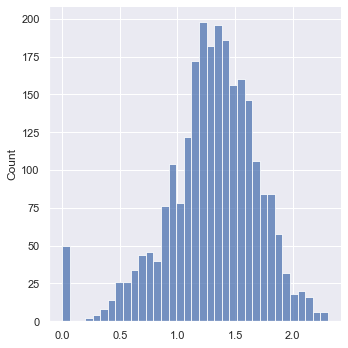

In [23]:
NORM_P = 2
points = features_df.to_numpy()
print(points.shape)
distance_matrix = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(points, "minkowski", p=NORM_P))
sns.displot(distance_matrix.flatten())

In [24]:
from simanneal import Annealer

rng = np.random.default_rng()

class BottleneckAnnealer(Annealer):
    copy_strategy = "method"  # Use `self.state.copy()` to copy the state
    
    # Override default hyperparameters
    Tmin = 1e-6
    Tmax = 1e3
    steps = 250000
    updates = 250

    def __init__(self, *args, path: np.ndarray, distance_matrix: np.ndarray, **kwargs):
        super().__init__(path, *args, **kwargs)
        self.distance_matrix = distance_matrix
        self.num_points = len(self.state)

    def move(self):
        """
        Randomly swap points
        """
        num_swaps = int(np.random.rand() * 4)
        swaps = rng.choice(self.num_points, (num_swaps, 2), replace=False)
        self.state[swaps] = self.state[swaps[..., ::-1]]

    def energy(self):
        """
        Compute the energy of the current path
        """
        # Find the length of the edge from each node in the path to the next
        source_nodes = self.state
        target_nodes = np.roll(source_nodes, 1)
        edge_distances = self.distance_matrix[source_nodes, target_nodes]
        max_edge_length = edge_distances.max()
#         mean_edge_length = edge_distances.mean()
        energy = max_edge_length
        return energy

### Initialize the annealer

In [25]:
annealer = BottleneckAnnealer(path=np.arange(len(points)), distance_matrix=distance_matrix)
print(f"Start energy: {annealer.energy()}")

Start energy: 2.1450137614582694


### Optimize

In [26]:
best_path, best_energy = annealer.anneal()
print(f"Best energy: {best_energy}")
print(best_path)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000          1.22    26.20%     0.00%     0:00:11     0:00:00

Best energy: 1.2159376692266204
[11 43  5 22 42 38 36 46 26 48 12 19 29 10  6 28 15 34  8 27 18 30 25 39
 20 14  4 16 23  3  0 35 45 41 31 47 21 49  9 17  2 44  1  7 40 13 37 33
 32 24]


In [27]:
features_df.iloc[best_path]

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,mode
11,0.456790,0.294118,0.000000,0.000000,0.081703,9.401985e-01,0.733333,0.912756,0.209222,0.582529,0.0
43,0.580247,0.766296,0.300792,0.465239,0.048331,5.082991e-01,0.934359,0.118532,0.056945,0.511885,0.0
5,0.395062,0.120827,0.172823,0.486858,0.096279,1.000000e+00,0.829744,0.097473,0.000000,0.967800,0.0
22,0.308642,0.109698,0.145119,0.221059,0.055619,8.759673e-01,0.955897,0.265945,0.005994,0.386315,1.0
42,0.419753,0.662957,0.641161,0.479289,0.003069,3.752863e-02,0.783590,0.088147,0.131988,0.294175,1.0
38,0.518519,0.653418,0.503958,0.455752,0.005370,7.395337e-03,0.908718,0.750301,0.121614,0.315638,1.0
36,0.246914,0.491256,0.771768,0.401732,0.010740,6.177159e-03,0.970256,0.332130,0.838617,0.620593,1.0
46,0.567901,0.806041,0.616095,0.559749,0.086690,8.503990e-04,0.739487,0.088448,0.100865,0.424346,1.0
26,0.345679,0.478537,0.587071,0.525222,0.390104,7.472858e-03,0.064103,0.148616,0.414409,0.293848,1.0
48,0.012346,0.367250,0.864116,0.586707,0.221327,1.107435e-07,0.913846,0.581829,0.280692,0.205842,1.0


In [28]:
optimally_ordered_tracks = [track_list[idx]["uri"] for idx in best_path]
for url in optimally_ordered_tracks:
    print(url)

spotify:track:14ncdb9wiuGp0PliplZkad
spotify:track:0lRbPTSlLjBk8Yl7x7UULj
spotify:track:6FKPPNjMFEekgUfy5v838t
spotify:track:4oj7gtV7uc7wkw6zijTr4X
spotify:track:0wVSTsBNYZdrwSDiEE6hIe
spotify:track:7IEHc5BVgiN1J6lSSkzWj3
spotify:track:12jK9HBnD9UyVmoAWeBDIR
spotify:track:64xHf70oM67cWZ3zUSG3Mv
spotify:track:5imIIivQiyz0LzysOwOU2O
spotify:track:2vzbNt9SHL1DQ2o1LtWuuR
spotify:track:18IARgL5t0TkfCvARd8Ndn
spotify:track:5XZK1CC3LybEKGdmH04YBC
spotify:track:7o9wpDM622yGhHJTxDd4dQ
spotify:track:6109JNRSWsyph4120DTx7l
spotify:track:235UDSE1c89C1Ok3XZiHeb
spotify:track:5VcOZYRlC02MDPD95bi0rs
spotify:track:4T6FWA703h6H7zk1FoSARw
spotify:track:0m9Td3Cuc0frjFJWxvYpon
spotify:track:6037kWfTxGjlfcmI919HYB
spotify:track:7fVlbM9hxmv3Omz4UPcsy8
spotify:track:2BlDX1yfT0ea5wo0vjCKKa
spotify:track:6kjK5VTCfPIOk4US3Pd6Gs
spotify:track:570Sz8fASQY47LDVZ5GzTB
spotify:track:70NEQeOCAz5jl6CS8SQ6Vg
spotify:track:4XRaGryj589Fee9HqIDwup
spotify:track:0ClnfM4PI0wjlCVTJc9lP7
spotify:track:4HWcWgleTuUAWnVPNwW4CM
s